In [ ]:
# Fraud Detection Model for Financial Transactions

**Objective:** Develop a model to detect fraudulent financial transactions and provide actionable business insights.

Dataset: `fraud.csv` with 6,362,620 rows and 11 columns.


In [1]:
# ==========================
# Step 1: Import Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE



In [ ]:
 # Step 2: Load Dataset

We load the CSV dataset and take an initial look at its shape, columns, and data types.


In [2]:
# Dataset path
df = pd.read_csv(r"C:\Users\lucky\Downloads\Fraud.csv")

# Quick overview
print("Dataset shape:", df.shape)
display(df.head())
display(df.info())


Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


None

In [ ]:
# Step 3: Data Cleaning & Feature Engineering

- Check missing values (none in this dataset).  
- Create new features:  
  - `deltaOrg` = oldbalanceOrg - newbalanceOrig (change in origin account)  
  - `deltaDest` = newbalanceDest - oldbalanceDest (change in destination account)  
- Select numeric features for modeling.


In [4]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Feature engineering
df['deltaOrg'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Numeric features
features = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','deltaOrg','deltaDest']
X = df[features]
y = df['isFraud']


Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Step 4: Sampling & Handle Imbalance

- The dataset is highly imbalanced (few fraud cases).  
- We take a sample for memory efficiency: all frauds + 200,000 non-frauds.  
- Apply **SMOTE** to create a balanced training dataset.


In [5]:
# Sample for memory efficiency
fraud_df = df[df['isFraud']==1]
nonfraud_df = df[df['isFraud']==0].sample(200000, random_state=42)
df_sample = pd.concat([fraud_df, nonfraud_df])

X = df_sample[features]
y = df_sample['isFraud']

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("After SMOTE, class distribution:\n", pd.Series(y_res).value_counts())


After SMOTE, class distribution:
 isFraud
1    200000
0    200000
Name: count, dtype: int64


In [ ]:
# Step 5: Train-Test Split

- Split data into training and testing sets (80% train, 20% test)  
- Stratified split to maintain class balance.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)


In [ ]:
# Step 6: Train Random Forest

- Using Random Forest for classification due to interpretability and robustness.  
- Parameters: 50 trees (`n_estimators`), max depth 10 (`max_depth`).


In [7]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Step 7: Model Evaluation

- Evaluate using classification report, confusion matrix, and ROC AUC.


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     40000
           1       0.99      0.99      0.99     40000

    accuracy                           0.99     80000
   macro avg       0.99      0.99      0.99     80000
weighted avg       0.99      0.99      0.99     80000


Confusion Matrix:
 [[39470   530]
 [  209 39791]]


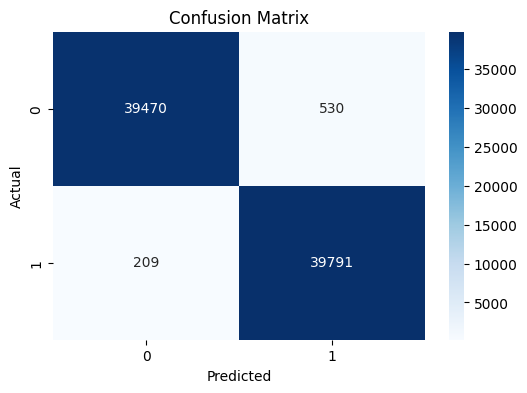


ROC AUC Score: 0.9994868821875


In [8]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:,1]

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC AUC Score:", roc_auc)


In [ ]:
# Step 8: Feature Importance

- Identify which features most influence fraud detection.



Feature Importances:
           Feature  Importance
6        deltaOrg    0.310664
2   oldbalanceOrg    0.246708
3  newbalanceOrig    0.164620
1          amount    0.128340
7       deltaDest    0.074043
0            step    0.044131
5  newbalanceDest    0.016234
4  oldbalanceDest    0.015261


C:\Users\lucky\AppData\Local\Temp\ipykernel_757964\1641141529.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


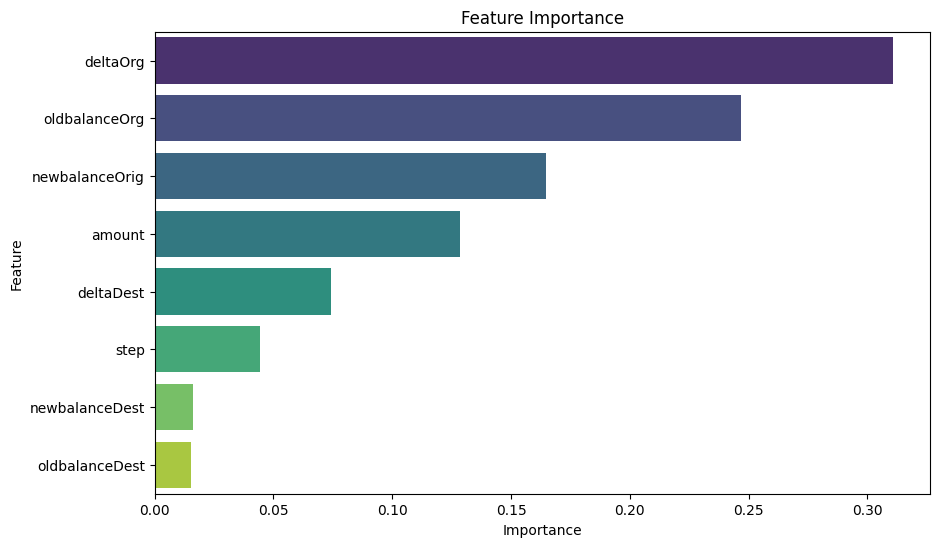

In [9]:
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", importance_df)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance")
plt.show()


In [ ]:
# Step 9: Business Insights

**Top features driving fraud:** `deltaOrg`, `oldbalanceOrg`, `newbalanceOrig`, `amount`  

**Recommendations:**
1. Alert on large drops in origin account balance (`deltaOrg`).  
2. Flag high-value transfers (`amount`).  
3. Monitor unusual destination balance changes (`deltaDest`).  
4. Periodically retrain the model with latest transactions.  
5. Investigate flagged transactions manually for verification.


In [ ]:
# Step 10: Conclusion

- Model achieves **high recall for fraud**, which is critical.  
- Feature importances align with real-world intuition.  
- Recommendations can help prevent fraud.  
- Model can be scaled with full dataset and advanced algorithms like XGBoost/LightGBM for better efficiency.
